In [50]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import concatenate,Bidirectional

In [42]:

def _build_cnn_lstm_model(sequence_length, n_features, n_outputs=1):
    """
    Build a hybrid CNN-LSTM model for stock price prediction

    Args:
        sequence_length: Number of time steps in each input sequence
        n_features: Number of features per time step
        n_outputs: Number of output values to predict

    Returns:
        Compiled Keras model
    """
    # Input layer
    input_layer = Input(shape=(sequence_length, n_features))

    # CNN layers for spatial feature extraction
    conv1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling1D(pool_size=2)(conv2)

    # LSTM layers for temporal feature extraction
    lstm1 = LSTM(units=100, return_sequences=True)(conv2)
    lstm1 = Dropout(0.2)(lstm1)

    lstm2 = LSTM(units=100, return_sequences=False)(lstm1)
    lstm2 = Dropout(0.2)(lstm2)

    # Dense layers for prediction
    dense1 = Dense(64, activation='relu')(lstm2)
    dense1 = Dropout(0.2)(dense1)

    # Output layer
    if n_outputs == 1:
        output_layer = Dense(1, activation='sigmoid')(dense1)  # Binary classification (up/down)
    else:
        output_layer = Dense(n_outputs, activation='softmax')(dense1)  # Multi-class classification

    # Create and compile model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [51]:
def build_cnn_lstm_model(sequence_length, n_features, output_size=1):
    """
    Build a hybrid CNN-LSTM model for stock trend prediction

    Parameters:
    -----------
    sequence_length : int
        Number of time steps in each sequence
    n_features : int
        Number of features at each time step
    output_size : int
        Number of output classes (1 for regression, 2+ for classification)

    Returns:
    --------
    model : tf.keras.Model
        Compiled CNN-LSTM model
    """
    # Input layer
    input_layer = Input(shape=(sequence_length, n_features))

    # CNN Branch for spatial feature extraction
    # First conv block
    conv1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling1D(pool_size=2)(conv1)

    # Second conv block
    conv2 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling1D(pool_size=2)(conv2)

    # LSTM layer for temporal dependencies
    lstm_out = LSTM(units=100, return_sequences=True)(conv2)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(units=50)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)

    # Dense layers for final prediction
    dense = Dense(units=64, activation='relu')(lstm_out)
    dense = Dropout(0.3)(dense)
    dense = Dense(units=32, activation='relu')(dense)

    # Output layer - adjust based on task
    if output_size == 1:  # Regression
        output = Dense(units=1, activation='linear')(dense)
    else:  # Classification
        output = Dense(units=output_size, activation='softmax')(dense)

    # Create model
    model = Model(inputs=input_layer, outputs=output)

    # Compile model - adjust based on task
    if output_size == 1:  # Regression
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    else:  # Classification
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

    return model

# Model instantiation example
#sequence_length = 20  # Based on your preprocessed data
#n_features = 9  # Based on your preprocessed data
#output_size = 3  # For classification: -1 (down), 0 (neutral), 1 (up)

#model = build_cnn_lstm_model(sequence_length, n_features, output_size)
#model.summary()

In [44]:
# Option 2: Balanced sampling during training
from tensorflow.keras.utils import Sequence
from sklearn.utils import class_weight

class BalancedDataGenerator(Sequence):
    def __init__(self, x, y, batch_size=128):
        self.x = x
        self.y = y
        self.batch_size = batch_size

        # Find indices for each class
        self.indices_0 = np.where(y == 0)[0]
        self.indices_1 = np.where(y == 1)[0]

        # Determine number of batches
        self.n_batches = min(len(self.indices_0), len(self.indices_1)) // (self.batch_size // 2)

    def __len__(self):
        return self.n_batches

    def __getitem__(self, idx):
        # Sample equally from both classes
        idx_0 = np.random.choice(self.indices_0, self.batch_size // 2, replace=False)
        idx_1 = np.random.choice(self.indices_1, self.batch_size // 2, replace=False)
        idx = np.concatenate([idx_0, idx_1])

        return self.x[idx], self.y[idx]

In [45]:
def build_enhanced_cnn_lstm_model(sequence_length, n_features, n_outputs=1):
    # Input layer
    input_layer = Input(shape=(sequence_length, n_features))

    # Multiple CNN branches with different kernel sizes to capture patterns at different scales
    # Branch 1: Short-term patterns
    conv1_branch1 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(input_layer)
    conv1_branch1 = BatchNormalization()(conv1_branch1)
    conv1_branch1 = MaxPooling1D(pool_size=2)(conv1_branch1)

    # Branch 2: Medium-term patterns
    conv1_branch2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
    conv1_branch2 = BatchNormalization()(conv1_branch2)
    conv1_branch2 = MaxPooling1D(pool_size=2)(conv1_branch2)

    # Branch 3: Longer-term patterns
    conv1_branch3 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_layer)
    conv1_branch3 = BatchNormalization()(conv1_branch3)
    conv1_branch3 = MaxPooling1D(pool_size=2)(conv1_branch3)

    # Merge CNN branches
    merged = concatenate([conv1_branch1, conv1_branch2, conv1_branch3])

    # Additional convolutional layer after merging
    conv2 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(merged)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling1D(pool_size=2)(conv2)

    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(units=100, return_sequences=True))(conv2)
    lstm1 = Dropout(0.3)(lstm1)

    lstm2 = Bidirectional(LSTM(units=100, return_sequences=False))(lstm1)
    lstm2 = Dropout(0.3)(lstm2)

    # Dense layers with skip connections
    dense1 = Dense(64, activation='relu')(lstm2)
    dense1 = Dropout(0.3)(dense1)

    # Output layer
    if n_outputs == 1:
        output_layer = Dense(1, activation='sigmoid')(dense1)
    else:
        output_layer = Dense(n_outputs, activation='softmax')(dense1)

    # Create and compile model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def _train_model(model, X_train, y_train, X_val, y_val, batch_size=128, epochs=100):
    """
    Train the model with early stopping and learning rate reduction

    Args:
        model: The compiled model to train
        X_train, y_train: Training data
        X_val, y_val: Validation data
        batch_size: Batch size for training
        epochs: Maximum number of epochs

    Returns:
        Trained model and training history
    """
    # Prepare callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # Convert target to binary classification if needed
    if len(y_train.shape) == 1:
        # Convert regression to binary classification (up/down)
        y_train_binary = (y_train > 0).astype(int)
        y_val_binary = (y_val > 0).astype(int)
    else:
        y_train_binary = y_train
        y_val_binary = y_val

    # Compile model for binary classification
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        X_train, y_train_binary,
        validation_data=(X_val, y_val_binary),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance on test data

    Args:
        model: Trained model
        X_test, y_test: Test data

    Returns:
        Dictionary of evaluation metrics
    """
    # Convert target to binary classification if needed
    if len(y_test.shape) == 1:
        y_test_binary = (y_test > 0).astype(int)
    else:
        y_test_binary = y_test

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred)
    recall = recall_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)

    # Create confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred)

    # Return metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

    return metrics

def plot_training_history(history):
    """
    Plot the training and validation loss/accuracy

    Args:
        history: Training history from model.fit()
    """
    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    else:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.show()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(cm):
    """
    Plot confusion matrix

    Args:
        cm: Confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [53]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=100):
    """
    Train the CNN-LSTM model with callbacks for optimization
    """
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        'best_cnn_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot metric (accuracy for classification, MAE for regression)
    plt.subplot(1, 2, 2)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
    else:
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Mean Absolute Error')

    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    return model, history

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 20, 11)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 20, 64)         │          1,472 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 20, 64)         │          2,176 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 20, 64)         │          3,584 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 20, 64)         │            256 │ conv1d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 20, 64)         │            256 │ conv1d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 20, 64)         │            256 │ conv1d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_13          │ (None, 10, 64)         │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_14          │ (None, 10, 64)         │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_15          │ (None, 10, 64)         │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 10, 192)        │              0 │ max_pooling1d_13[0][0… │
│ (Concatenate)             │                        │                │ max_pooling1d_14[0][0… │
│                           │                        │                │ max_pooling1d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 10, 128)        │         73,856 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 10, 128)        │            512 │ conv1d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_16          │ (None, 5, 128)         │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├──────────────────────

 Total params: 519,297 (1.98 MB)

 Trainable params: 518,657 (1.98 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 371s 99ms/step - accuracy: 0.4800 - loss: nan - val_accuracy: 0.4809 - val_loss: nan - learning_rate: 0.0010
Epoch 2/100
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 389s 101ms/step - accuracy: 0.4799 - loss: nan - val_accuracy: 0.4809 - val_loss: nan - learning_rate: 0.0010
Epoch 3/100
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 357s 99ms/step - accuracy: 0.4799 - loss: nan - val_accuracy: 0.4809 - val_loss: nan - learning_rate: 0.0010
Epoch 4/100
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 366s 101ms/step - accuracy: 0.4799 - loss: nan - val_accuracy: 0.4809 - val_loss: nan - learning_rate: 0.0010
Epoch 5/100
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 355s 98ms/step - accuracy: 0.4799 - loss: nan - val_accuracy: 0.4809 - val_loss: nan - learning_rate: 0.0010
Epoch 6/100
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 392s 101ms/step - accuracy: 0.4799 - loss: nan - val_accuracy: 0.4809 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 7/100
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 381s 101ms/step - accuracy: 0.4799 - l

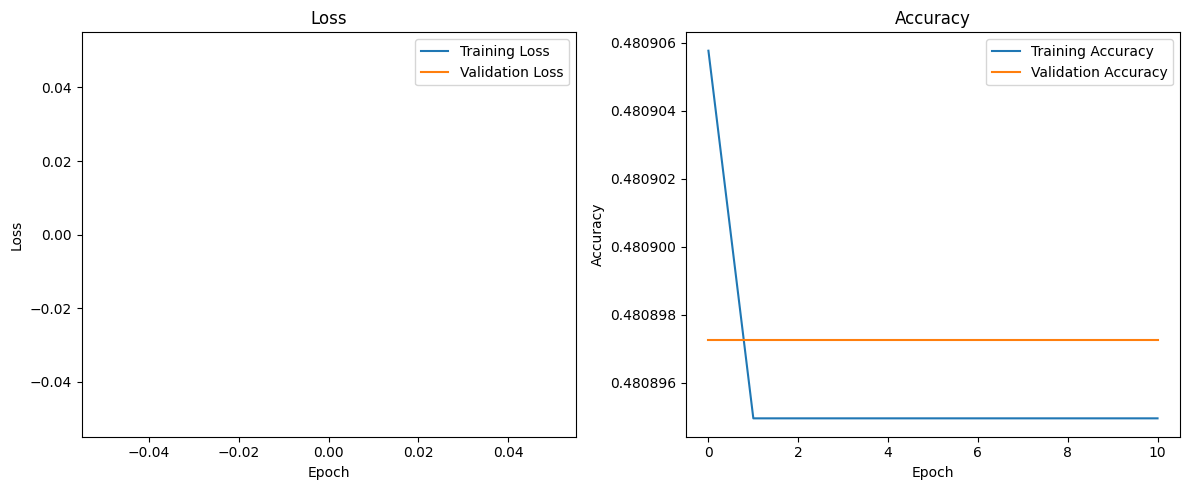

2495/2495 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


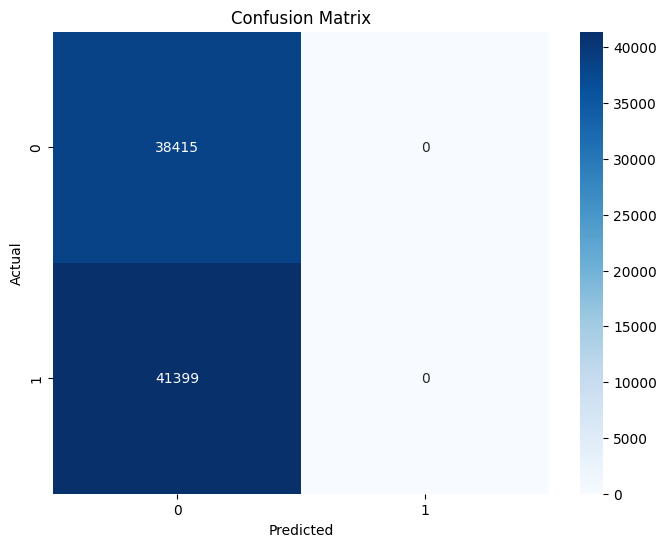

In [ ]:
import numpy as np
import logging
from pathlib import Path
from tensorflow.keras.utils import plot_model

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def main():
    try:
        # Set random seed for reproducibility
        np.random.seed(42)
        tf.random.set_seed(42)

        # Load preprocessed data
        logger.info("Loading preprocessed data...")
        data_dir = Path('/content/drive/MyDrive/preprocessed_data')

        X_train = np.load(data_dir / 'X_train.npy')
        y_train = np.load(data_dir / 'y_train.npy')
        X_val = np.load(data_dir / 'X_val.npy')
        y_val = np.load(data_dir / 'y_val.npy')
        X_test = np.load(data_dir / 'X_test.npy')
        y_test = np.load(data_dir / 'y_test.npy')

        logger.info(f"Training data shapes: X={X_train.shape}, y={y_train.shape}")
        logger.info(f"Validation data shapes: X={X_val.shape}, y={y_val.shape}")
        logger.info(f"Test data shapes: X={X_test.shape}, y={y_test.shape}")

        # Build model
        logger.info("Building CNN-LSTM model...")
        sequence_length = X_train.shape[1]
        n_features = X_train.shape[2]

        #model = build_cnn_lstm_model(sequence_length, n_features)
        #model.summary()
        model = build_enhanced_cnn_lstm_model(sequence_length, n_features)
        model.summary()
        # Plot model architecture
        plot_model(model, to_file='model_architecture.png', show_shapes=True)

        # Train model
        logger.info("Training model...")
        trained_model, history = train_model(model, X_train, y_train, X_val, y_val)

        # Plot training history
        logger.info("Plotting training history...")
        plot_training_history(history)

        # Evaluate model
        logger.info("Evaluating model on test data...")
        metrics = evaluate_model(trained_model, X_test, y_test)

        logger.info(f"Test Accuracy: {metrics['accuracy']:.4f}")
        logger.info(f"Test Precision: {metrics['precision']:.4f}")
        logger.info(f"Test Recall: {metrics['recall']:.4f}")
        logger.info(f"Test F1 Score: {metrics['f1_score']:.4f}")

        # Plot confusion matrix
        logger.info("Plotting confusion matrix...")
        plot_confusion_matrix(metrics['confusion_matrix'])

        logger.info("Model training and evaluation completed successfully!")

    except Exception as e:
        logger.error(f"Error in model training pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-03-22 13:57:00,756 - __main__ - INFO - Loading preprocessed data...
2025-03-22 13:57:00,781 - __main__ - INFO - (32436, 20, 11)
2025-03-22 13:57:00,787 - __main__ - INFO - load completed
2025-03-22 13:57:00,788 - __main__ - INFO - Training data shapes: X=(32436, 20, 11), y=(32436,)
2025-03-22 13:57:00,789 - __main__ - INFO - Validation data shapes: X=(3538, 20, 11), y=(3538,)
2025-03-22 13:57:00,790 - __main__ - INFO - Test data shapes: X=(5406, 20, 11), y=(5406,)
2025-03-22 13:57:00,790 - __main__ - INFO - Building CNN-LSTM model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 20, 64)         │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 5, 100)         │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,825 (604.79 KB)

 Trainable params: 154,441 (603.29 KB)

 Non-trainable params: 384 (1.50 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


2025-03-22 13:57:00,940 - __main__ - INFO - Training model...


Epoch 1/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0011 - mae: 0.0207 - val_loss: 3.1696e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 2/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 4.2309e-04 - mae: 0.0145 - val_loss: 3.1711e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 3/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 4.2131e-04 - mae: 0.0144 - val_loss: 3.1734e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 4/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 4.2113e-04 - mae: 0.0144 - val_loss: 3.1719e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 5/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 4.2130e-04 - mae: 0.0144 - val_loss: 3.1731e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 6/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 4.2112e-04 - mae: 0.0144 - val_loss: 3.1737e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 7/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 4.2023e-0

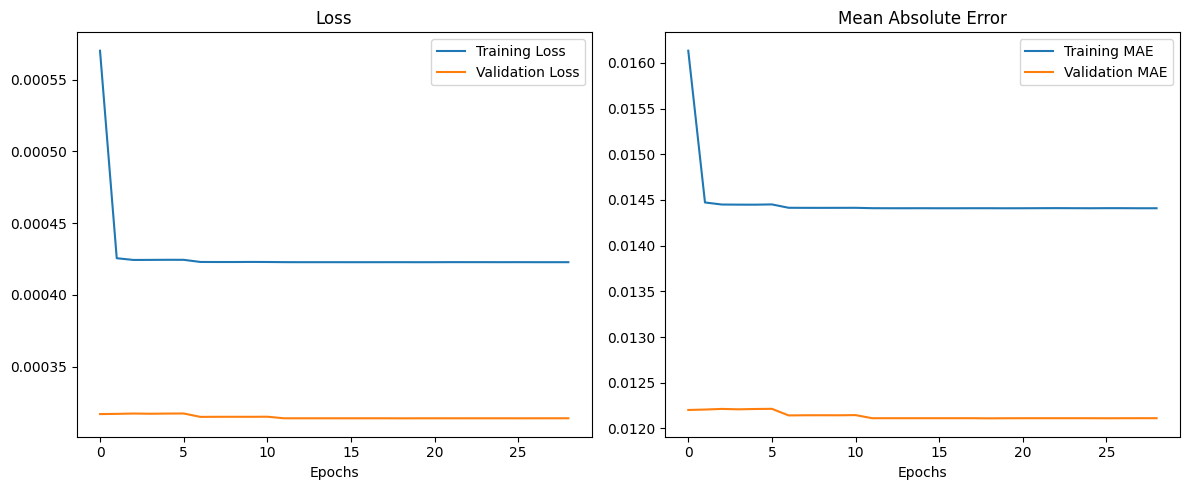

2025-03-22 14:02:10,757 - __main__ - INFO - Plotting training history...


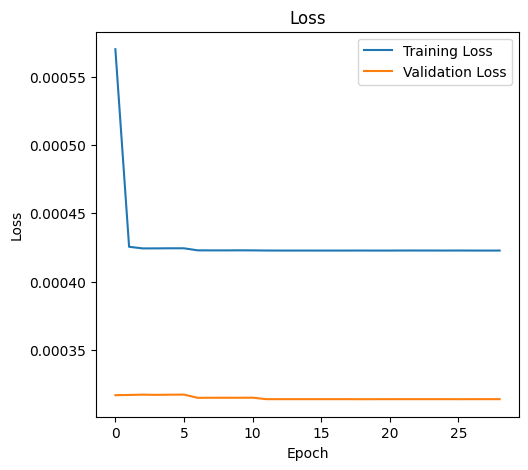

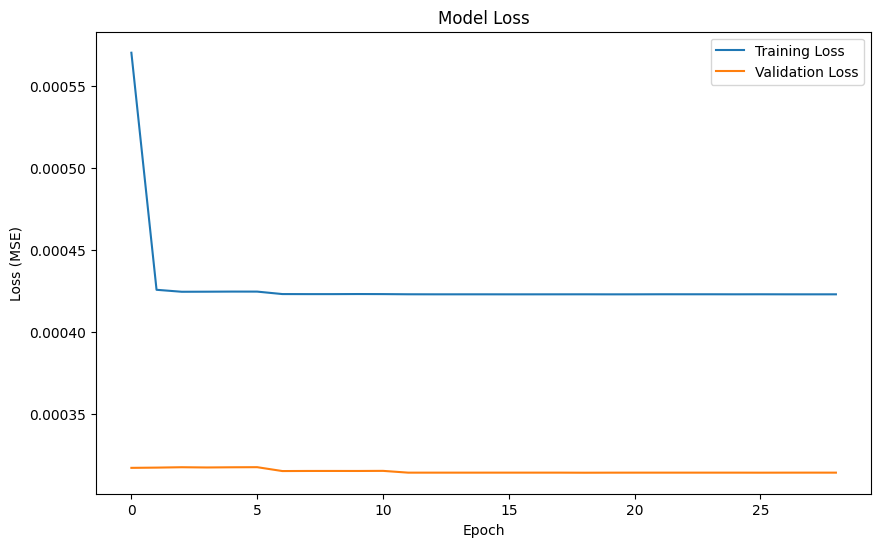

<Figure size 640x480 with 0 Axes>

2025-03-22 14:02:11,163 - __main__ - INFO - Evaluating model on test data...


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-03-22 14:02:12,553 - __main__ - INFO - Test Accuracy: 0.4726
2025-03-22 14:02:12,553 - __main__ - INFO - Test Precision: 0.0000
2025-03-22 14:02:12,554 - __main__ - INFO - Test Recall: 0.0000
2025-03-22 14:02:12,555 - __main__ - INFO - Test F1 Score: 0.0000
2025-03-22 14:02:12,555 - __main__ - INFO - Plotting confusion matrix...


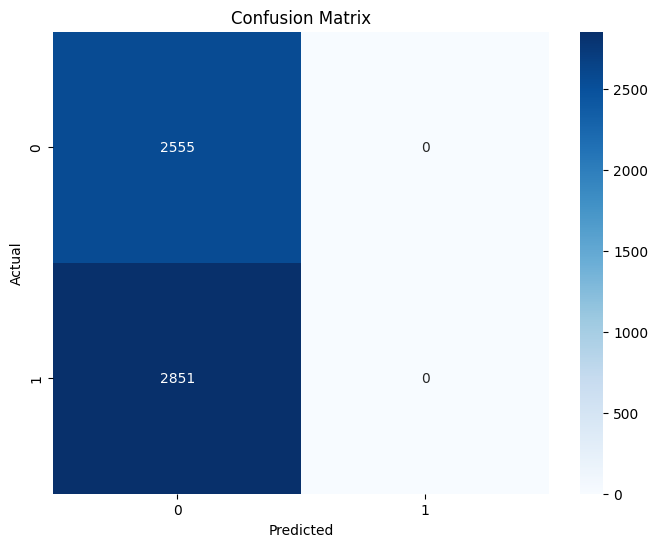

2025-03-22 14:02:12,841 - __main__ - INFO - Model training and evaluation completed successfully!


In [59]:
import numpy as np
import os
import logging
from pathlib import Path
from tensorflow.keras.utils import plot_model

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def main():
    try:
        # Set random seed for reproducibility
        np.random.seed(42)
        tf.random.set_seed(42)

        # Load preprocessed data
        logger.info("Loading preprocessed data...")
        data_dir = Path('preprocessed_data')

        X_train = np.load(data_dir / 'X_train.npy')
        logger.info(X_train.shape)
        y_train = np.load(data_dir / 'y_train.npy')
        X_val = np.load(data_dir / 'X_val.npy')
        y_val = np.load(data_dir / 'y_val.npy')
        X_test = np.load(data_dir / 'X_test.npy')
        y_test = np.load(data_dir / 'y_test.npy')
        logger.info("load completed")
        logger.info(f"Training data shapes: X={X_train.shape}, y={y_train.shape}")
        logger.info(f"Validation data shapes: X={X_val.shape}, y={y_val.shape}")
        logger.info(f"Test data shapes: X={X_test.shape}, y={y_test.shape}")

        # Build model
        logger.info("Building CNN-LSTM model...")
        sequence_length = X_train.shape[1]
        n_features = X_train.shape[2]

        model = build_cnn_lstm_model(sequence_length, n_features)
        model.summary()
        #model = build_enhanced_cnn_lstm_model(sequence_length, n_features)
        #model.summary()
        # Plot model architecture
        plot_model(model, to_file='model_architecture.png', show_shapes=True)

        # Train model
        logger.info("Training model...")
        trained_model, history = train_model(model, X_train, y_train, X_val, y_val)

        # Plot training history
        logger.info("Plotting training history...")
        plot_training_history(history)

        # Evaluate model
        logger.info("Evaluating model on test data...")
        metrics = evaluate_model(trained_model, X_test, y_test)

        logger.info(f"Test Accuracy: {metrics['accuracy']:.4f}")
        logger.info(f"Test Precision: {metrics['precision']:.4f}")
        logger.info(f"Test Recall: {metrics['recall']:.4f}")
        logger.info(f"Test F1 Score: {metrics['f1_score']:.4f}")

        # Plot confusion matrix
        logger.info("Plotting confusion matrix...")
        plot_confusion_matrix(metrics['confusion_matrix'])

        logger.info("Model training and evaluation completed successfully!")

    except Exception as e:
        logger.error(f"Error in model training pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [8]:
import pandas as pd
import numpy as np

class TradingSignalGenerator:
    def __init__(self, model, threshold=0.5, holding_period=1):
        """
        Initialize the trading signal generator

        Parameters:
        -----------
        model : tf.keras.Model
            Trained CNN-LSTM model
        threshold : float
            Confidence threshold for generating signals
        holding_period : int
            Number of days to hold a position
        """
        self.model = model
        self.threshold = threshold
        self.holding_period = holding_period

    def generate_signals(self, X_test, price_data):
        """
        Generate trading signals from model predictions

        Parameters:
        -----------
        X_test : np.array
            Test data sequences
        price_data : pd.DataFrame
            Price data corresponding to test sequences

        Returns:
        --------
        signals_df : pd.DataFrame
            DataFrame with trading signals
        """
        # Get model predictions
        predictions = self.model.predict(X_test)

        # Convert predictions to signals based on model type
        if predictions.shape[1] > 1:  # Multi-class classification
            # Get class with highest probability
            signal_class = np.argmax(predictions, axis=1)
            # Convert to -1, 0, 1 (assuming 3 classes)
            signals = signal_class - 1  # Map 0,1,2 to -1,0,1
        else:  # Regression or binary classification
            # Thresholding
            signals = np.zeros(len(predictions))
            signals[predictions.flatten() > self.threshold] = 1
            signals[predictions.flatten() < -self.threshold] = -1

        # Create signals DataFrame
        signals_df = price_data.copy()
        signals_df['Signal'] = 0
        signals_df.loc[signals_df.index[-len(signals):], 'Signal'] = signals

        # Apply holding period logic
        position = 0
        hold_count = 0

        for i in range(len(signals_df)):
            if hold_count > 0:
                hold_count -= 1
                signals_df.iloc[i, signals_df.columns.get_loc('Signal')] = 0
            elif signals_df.iloc[i]['Signal'] != 0:
                position = signals_df.iloc[i]['Signal']
                hold_count = self.holding_period

        # Add position column (cumulative signal)
        signals_df['Position'] = signals_df['Signal'].cumsum()

        return signals_df

    def calculate_returns(self, signals_df, transaction_cost=0.001):
        """
        Calculate returns based on trading signals

        Parameters:
        -----------
        signals_df : pd.DataFrame
            DataFrame with trading signals
        transaction_cost : float
            Transaction cost as a percentage

        Returns:
        --------
        returns_df : pd.DataFrame
            DataFrame with strategy returns
        """
        returns_df = signals_df.copy()

        # Calculate daily returns
        returns_df['Daily_Return'] = returns_df['Close'].pct_change()

        # Calculate strategy returns
        returns_df['Strategy_Return'] = returns_df['Position'].shift(1) * returns_df['Daily_Return']

        # Account for transaction costs
        returns_df['Signal_Change'] = returns_df['Signal'].diff().abs()
        returns_df['Transaction_Cost'] = returns_df['Signal_Change'] * transaction_cost
        returns_df['Net_Strategy_Return'] = returns_df['Strategy_Return'] - returns_df['Transaction_Cost']

        # Calculate cumulative returns
        returns_df['Cumulative_Market_Return'] = (1 + returns_df['Daily_Return']).cumprod()
        returns_df['Cumulative_Strategy_Return'] = (1 + returns_df['Net_Strategy_Return']).cumprod()

        return returns_df

# Example usage
signal_generator = TradingSignalGenerator(trained_model, threshold=0.6)
signals_df = signal_generator.generate_signals(X_test, test_price_data)
returns_df = signal_generator.calculate_returns(signals_df)

NameError: name 'trained_model' is not defined

In [55]:
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class PerformanceAnalyzer:
    def __init__(self, returns_df):
        """
        Initialize the performance analyzer

        Parameters:
        -----------
        returns_df : pd.DataFrame
            DataFrame with strategy returns
        """
        self.returns_df = returns_df

    def calculate_metrics(self, risk_free_rate=0.02/252):
        """
        Calculate performance metrics

        Parameters:
        -----------
        risk_free_rate : float
            Daily risk-free rate

        Returns:
        --------
        metrics : dict
            Dictionary with performance metrics
        """
        # Extract daily returns
        strategy_returns = self.returns_df['Net_Strategy_Return'].dropna()
        market_returns = self.returns_df['Daily_Return'].dropna()

        # Calculate metrics
        metrics = {}

        # Total returns
        metrics['Total_Market_Return'] = self.returns_df['Cumulative_Market_Return'].iloc[-1] - 1
        metrics['Total_Strategy_Return'] = self.returns_df['Cumulative_Strategy_Return'].iloc[-1] - 1

        # Annualized returns (assuming 252 trading days per year)
        n_years = len(strategy_returns) / 252
        metrics['Annual_Market_Return'] = (1 + metrics['Total_Market_Return']) ** (1 / n_years) - 1
        metrics['Annual_Strategy_Return'] = (1 + metrics['Total_Strategy_Return']) ** (1 / n_years) - 1

        # Volatility
        metrics['Market_Volatility'] = market_returns.std() * np.sqrt(252)
        metrics['Strategy_Volatility'] = strategy_returns.std() * np.sqrt(252)

        # Sharpe ratio
        metrics['Market_Sharpe'] = (metrics['Annual_Market_Return'] - risk_free_rate*252) / metrics['Market_Volatility']
        metrics['Strategy_Sharpe'] = (metrics['Annual_Strategy_Return'] - risk_free_rate*252) / metrics['Strategy_Volatility']

        # Maximum drawdown
        market_cum_returns = (1 + market_returns).cumprod()
        strategy_cum_returns = (1 + strategy_returns).cumprod()

        market_peak = market_cum_returns.cummax()
        strategy_peak = strategy_cum_returns.cummax()

        market_drawdown = (market_cum_returns - market_peak) / market_peak
        strategy_drawdown = (strategy_cum_returns - strategy_peak) / strategy_peak

        metrics['Market_Max_Drawdown'] = market_drawdown.min()
        metrics['Strategy_Max_Drawdown'] = strategy_drawdown.min()

        # Win/Loss ratio
        winning_trades = strategy_returns[strategy_returns > 0]
        losing_trades = strategy_returns[strategy_returns < 0]

        metrics['Win_Rate'] = len(winning_trades) / (len(winning_trades) + len(losing_trades))

        # Profit factor (not accounting for zero returns)
        if len(winning_trades) > 0 and len(losing_trades) > 0:
            metrics['Profit_Factor'] = winning_trades.sum() / abs(losing_trades.sum())
        else:
            metrics['Profit_Factor'] = np.nan

        return metrics

    def plot_equity_curve(self):
        """
        Plot equity curve of strategy vs market
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.returns_df['Cumulative_Market_Return'], label='Market')
        plt.plot(self.returns_df['Cumulative_Strategy_Return'], label='Strategy')
        plt.title('Equity Curve Comparison')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig('equity_curve.png')
        plt.show()

    def plot_drawdown(self):
        """
        Plot drawdown of strategy vs market
        """
        # Calculate drawdown
        market_returns = self.returns_df['Daily_Return'].dropna()
        strategy_returns = self.returns_df['Net_Strategy_Return'].dropna()

        market_cum_returns = (1 + market_returns).cumprod()
        strategy_cum_returns = (1 + strategy_returns).cumprod()

        market_peak = market_cum_returns.cummax()
        strategy_peak = strategy_cum_returns.cummax()

        market_drawdown = (market_cum_returns - market_peak) / market_peak
        strategy_drawdown = (strategy_cum_returns - strategy_peak) / strategy_peak

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(market_drawdown, label='Market', alpha=0.7)
        plt.plot(strategy_drawdown, label='Strategy', alpha=0.7)
        plt.title('Drawdown Comparison')
        plt.xlabel('Date')
        plt.ylabel('Drawdown')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig('drawdown.png')
        plt.show()

    def generate_report(self):
        """
        Generate performance report
        """
        metrics = self.calculate_metrics()

        # Create summary table
        summary = pd.DataFrame({
            'Metric': [
                'Total Return',
                'Annualized Return',
                'Annualized Volatility',
                'Sharpe Ratio',
                'Maximum Drawdown',
                'Win Rate',
                'Profit Factor'
            ],
            'Market': [
                f"{metrics['Total_Market_Return']:.2%}",
                f"{metrics['Annual_Market_Return']:.2%}",
                f"{metrics['Market_Volatility']:.2%}",
                f"{metrics['Market_Sharpe']:.2f}",
                f"{metrics['Market_Max_Drawdown']:.2%}",
                "N/A",
                "N/A"
            ],
            'Strategy': [
                f"{metrics['Total_Strategy_Return']:.2%}",
                f"{metrics['Annual_Strategy_Return']:.2%}",
                f"{metrics['Strategy_Volatility']:.2%}",
                f"{metrics['Strategy_Sharpe']:.2f}",
                f"{metrics['Strategy_Max_Drawdown']:.2%}",
                f"{metrics['Win_Rate']:.2%}",
                f"{metrics['Profit_Factor']:.2f}"
            ]
        })

        # Plot visualizations
        self.plot_equity_curve()
        self.plot_drawdown()

        return summary

# Example usage
analyzer = PerformanceAnalyzer(returns_df)
performance_summary = analyzer.generate_report()
print(performance_summary)

In [30]:
import os

print(os.listdir(os.getcwd() + '/preprocessing/preprocessed_data'))



['X_train.npy', 'X_test.npy', 'y_train.npy', 'X_val.npy', 'y_test.npy', 'y_val.npy']
